# 0. Import neccesary libraries

In [1]:
import os
import math
import torch
from torchvision.transforms import Compose
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# 1. Visualize the dataset

In [2]:
class MUSDB18Spectrogram:
    """
    Class to compute and visualize spectrograms of audio files.
    
    Args:
        wav_file_path (str): Path to the WAV file.
        
    Attributes:
        wav_file_path (str): Path to the WAV file.
        audio_name (str): Name of the audio file extracted from the path.
        signal (np.ndarray): Audio signal loaded from the WAV file.
        sample_rate (int): Sample rate of the audio signal.
        f (np.ndarray): Frequency bins of the spectrogram.
        t (np.ndarray): Time bins of the spectrogram.
        spectrogram (np.ndarray): Computed spectrogram of the audio signal.
    """
    def __init__(self, spectrogram_tensor: torch.tensor, name: str='NONAME'):
        """
        Initializes the MUSDB18Spectrogram object.
        """
        self.spectrogram_mix = spectrogram_tensor[0,:,:][None, :]
        self.spectrogram_voc = spectrogram_tensor[1,:,:][None, :]
        self.name = name
        self.t = torch.arange(self.spectrogram_mix.shape[2])  # Time bins
        self.f = torch.arange(self.spectrogram_mix.shape[1])  # Frequency bins

    def visualize(self):
        """
        Visualize the spectrograms.
        """
        # Plot the spectrograms
        fig, axes = plt.subplots(2, 1, figsize=(20, 10))

        # Plot the mixture spectrogram
        im1 = axes[0].pcolormesh(self.t, self.f, 10 * torch.log10(self.spectrogram_mix[0] + 1e-8), cmap='inferno')  # Applying log scale for better visualization
        axes[0].set_ylabel('Frequency bin F (Hz)')
        axes[0].set_xlabel('Samples T (s)')
        axes[0].set_title(f'Mixture Spectrogram of {self.name}')
        plt.colorbar(im1, ax=axes[0], label='Intensity (dB)')  # Add colorbar to the subplot

        # Plot the vocals spectrogram
        im2 = axes[1].pcolormesh(self.t, self.f, 10 * torch.log10(self.spectrogram_voc[0] + 1e-8), cmap='inferno')  # Applying log scale for better visualization
        axes[1].set_ylabel('Frequency bin F (Hz)')
        axes[1].set_xlabel('Samples T (s)')
        axes[1].set_title(f'Vocals Spectrogram of {self.name}')
        plt.colorbar(im2, ax=axes[1], label='Intensity (dB)')  # Add colorbar to the subplot

        plt.show()  # Display the plot



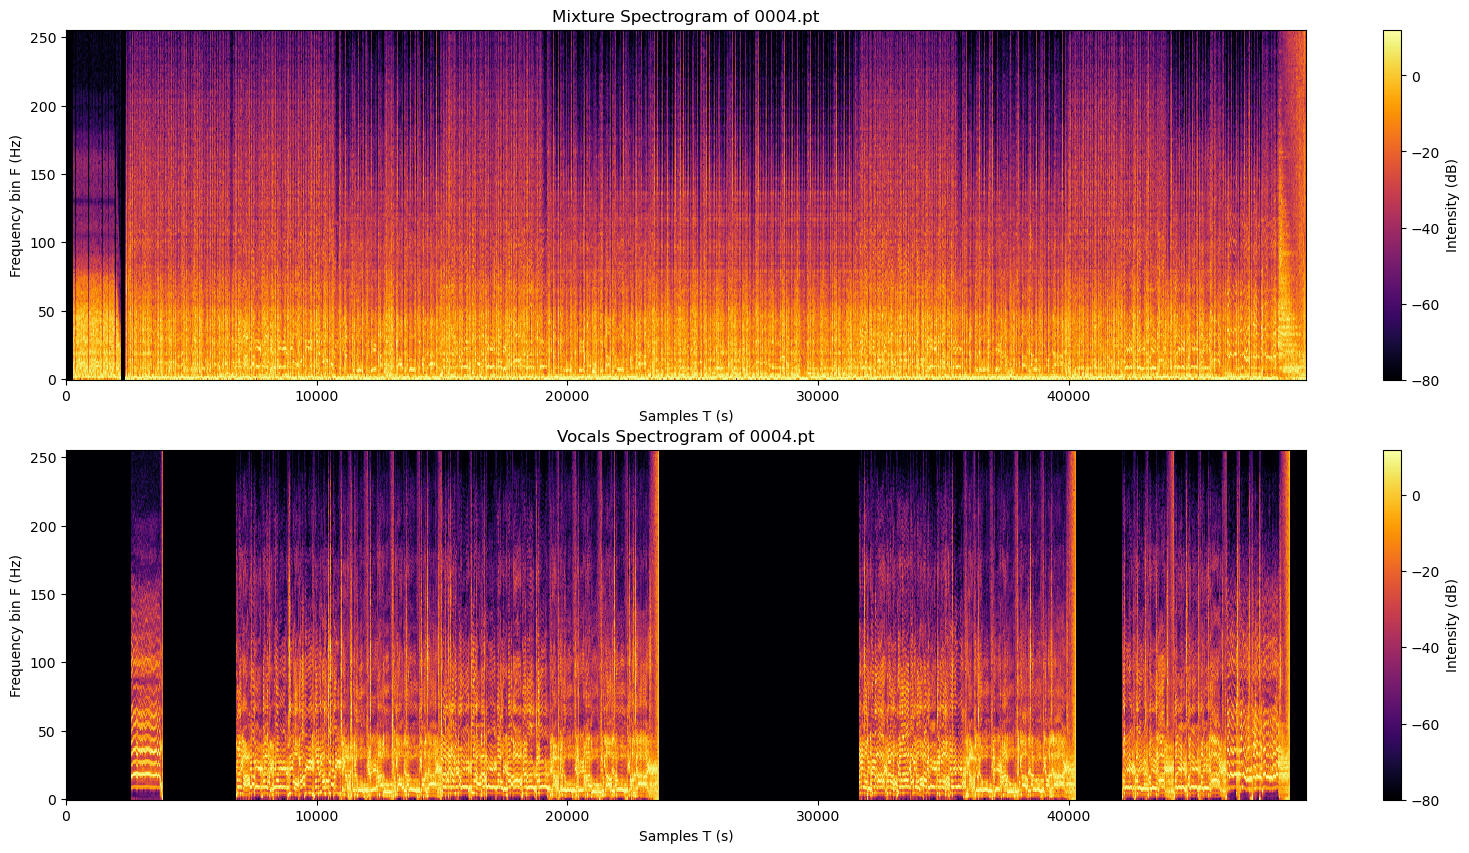

torch.Size([1, 256, 49462])

In [3]:
filename = './music_data/musdb18hq_processed/train_spectrograms/0004.pt'
spectrogram_tensor = torch.load(filename)
my_spectrogram = MUSDB18Spectrogram(spectrogram_tensor, filename[-7:])
my_spectrogram.visualize()

my_spectrogram.spectrogram_voc.shape

# 2. Create Dataset

In [11]:
#  We will create a class that inherits from Dataset

class MUSDB18Dataset(Dataset):

    def __init__(self,root: str, transform=None):
                    
        self.root = root
        self.transform = transform
        self.data = []
        self.samples_per_data = 256

        for filename in os.listdir(self.root):

            # create temporary spectrogram
            spectrogram_tensor = torch.load(f'{self.root}{filename}')

            for i in range(math.floor(spectrogram_tensor.shape[2] / self.samples_per_data)):

                new_tens = MUSDB18Spectrogram(spectrogram_tensor[:,:,i*self.samples_per_data:(i+1)*self.samples_per_data], f'{filename}, part {i}')

                self.data.append(new_tens)

    def __getitem__(self, index: int):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        spectrogram = self.data[index]

        if self.transform is not None:
            return self.transform(spectrogram.spectrogram_mix), self.transform(spectrogram.spectrogram_voc)
        else:
            return spectrogram.spectrogram_mix, spectrogram.spectrogram_voc
    
    def __len__(self):
        """Total number of samples"""
        return len(self.data)
    
    def show_spectrogram(self, index: int):
        mix, voc = self.__getitem__(index)
        MUSDB18Spectrogram(torch.cat((mix, voc), 0)).visualize()
        
        

In [14]:
from torchvision.transforms import Resize, Normalize, GaussianBlur

#train_spectrogram_library = './music_data/musdb18hq_processed/train_spectrograms/'
test_spectrogram_library = './music_data/musdb18hq_processed/test_spectrograms/'

image_size = (1, 256, 256)
mean = [0.485]
std = [0.229] 

transform_composition = Compose([Normalize(mean=mean,std=std), GaussianBlur(1)])

#music_dataset_train = MUSDB18Dataset(train_spectrogram_library, transform_composition)
music_dataset_test = MUSDB18Dataset(test_spectrogram_library, transform_composition)


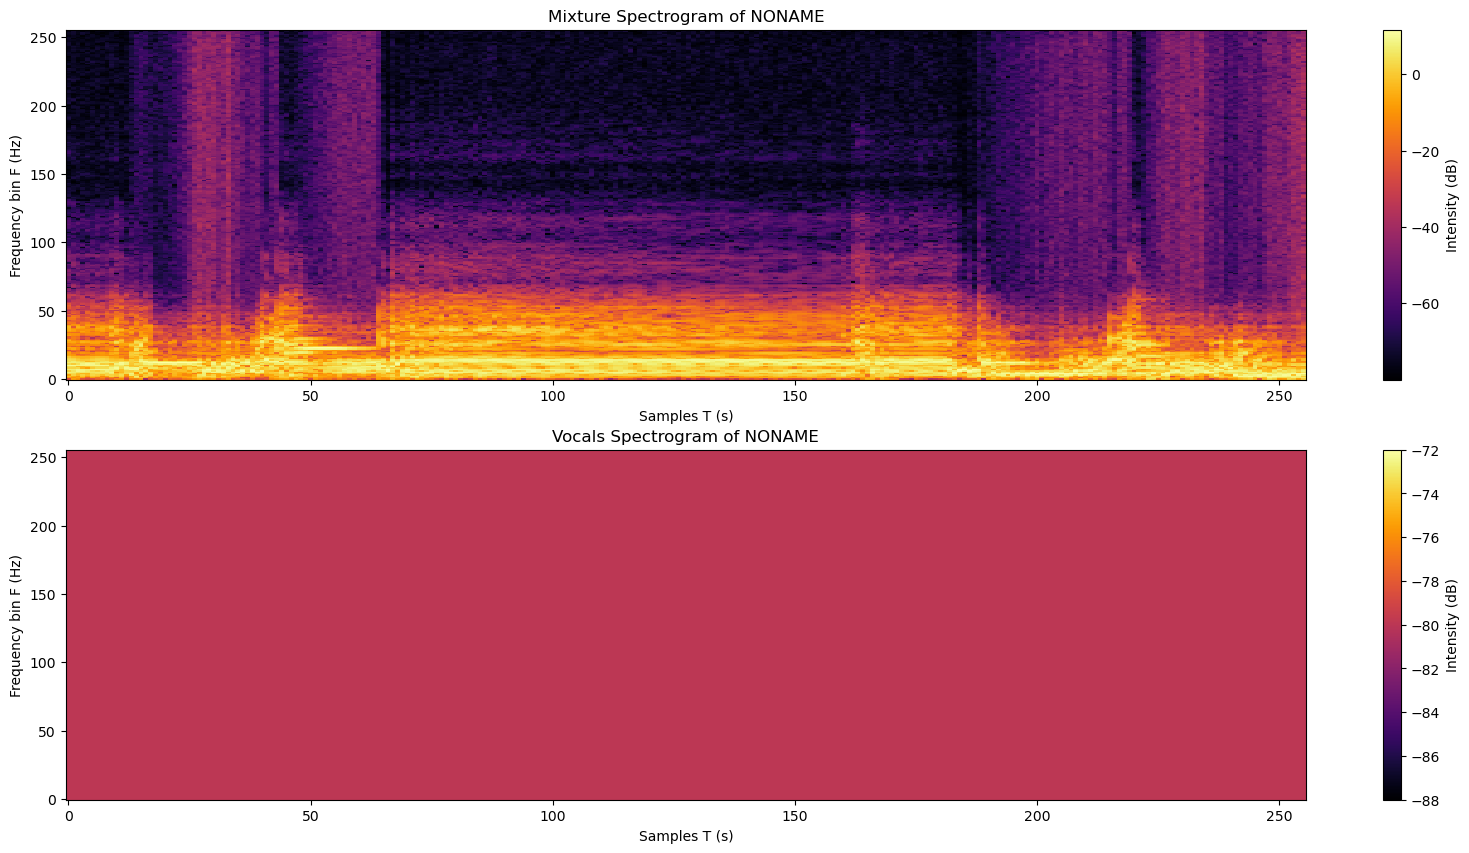

In [15]:
a, b = music_dataset_test[0]

b

music_dataset_test.show_spectrogram(index=2)

# 3. Create DataLoader

8397


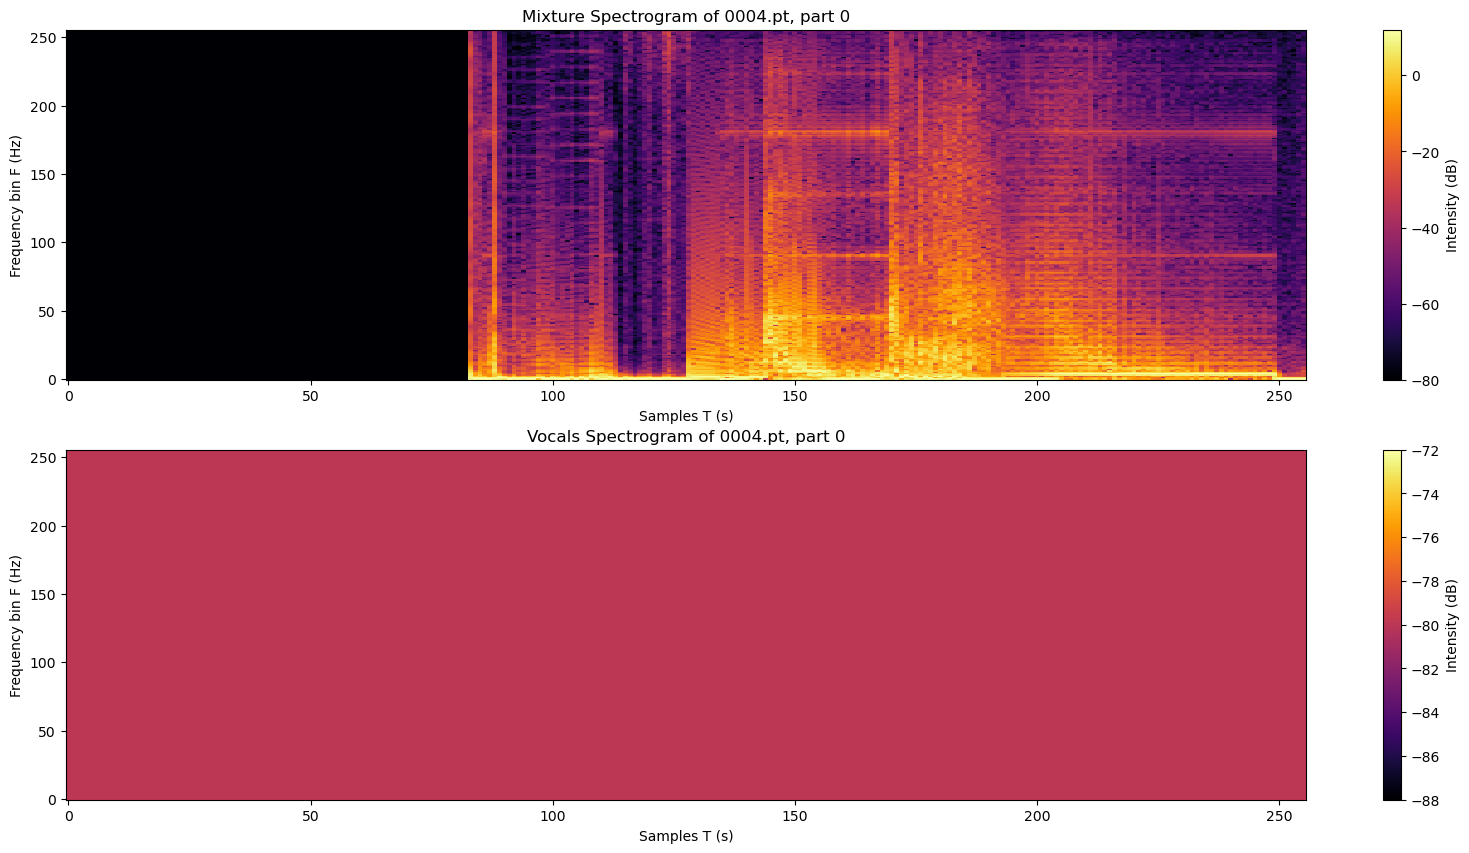

In [14]:
#train_dataloader = torch.utils.data.DataLoader(music_dataset_train, batch_size=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(music_dataset_test, batch_size=1, shuffle=True)


#a, b = music_dataset_train[1]

#print(len(music_dataset_train))
print(len(music_dataset_test))

music_dataset_test.show_spectrogram(index=1173)

a, b = music_dataset_test[1]

# 4. Load UNET Model

In [9]:
from model import UnetModel

device = 'cpu'
net = UnetModel()
net.transfer_weights(weight_path='./music_data/unet_latest.pth',device=device)

Loading weights for UNet


In [10]:
from trainer import UNETTrainer

trainer = UNETTrainer(model=net, train_dataloader=train_dataloader, val_dataloader=val_dataloader)
trainer.train_model(num_epochs=1)

Starting training
Training on device: cpu


ValueError: expected 4D input (got 3D input)